In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers

/Users/pa09251514/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
stock_data = pd.read_csv('TSLA.csv')
stock_data.drop(['Adj Close'], axis=1, inplace=True)

original_open = stock_data['Open'].values
dates = pd.to_datetime(stock_data['Date'])

original_open

array([ 20.799999,  21.4     ,  20.858   , ..., 189.      , 190.179993,
       192.110001])

In [3]:
print(stock_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1538 non-null   object 
 1   Open    1538 non-null   float64
 2   High    1538 non-null   float64
 3   Low     1538 non-null   float64
 4   Close   1538 non-null   float64
 5   Volume  1538 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 72.2+ KB
None


In [4]:
stock_data

,Date,Open,High,Low,Close,Volume
0,2018-01-02,20.799999,21.474001,20.733334,21.368668,65283000
1,2018-01-03,21.400000,21.683332,21.036667,21.150000,67822500
2,2018-01-04,20.858000,21.236668,20.378668,20.974667,149194500
3,2018-01-05,21.108000,21.149332,20.799999,21.105333,68868000
4,2018-01-08,21.066668,22.468000,21.033333,22.427334,147891000
...,...,...,...,...,...,...
1533,2024-02-06,177.210007,186.490005,177.110001,185.100006,122676000
1534,2024-02-07,188.179993,189.789993,182.679993,187.580002,111535200
1535,2024-02-08,189.000000,191.619995,185.580002,189.559998,83034000
1536,2024-02-09,190.179993,194.119995,189.479996,193.570007,84327600


In [5]:
cols = list(stock_data)[1:6]

stock_data = stock_data[cols].astype(float)

In [6]:
stock_data

,Open,High,Low,Close,Volume
0,20.799999,21.474001,20.733334,21.368668,65283000.0
1,21.400000,21.683332,21.036667,21.150000,67822500.0
2,20.858000,21.236668,20.378668,20.974667,149194500.0
3,21.108000,21.149332,20.799999,21.105333,68868000.0
4,21.066668,22.468000,21.033333,22.427334,147891000.0
...,...,...,...,...,...
1533,177.210007,186.490005,177.110001,185.100006,122676000.0
1534,188.179993,189.789993,182.679993,187.580002,111535200.0
1535,189.000000,191.619995,185.580002,189.559998,83034000.0
1536,190.179993,194.119995,189.479996,193.570007,84327600.0


In [7]:
# LSTM의 활성화 함수는 tanh & sigmoid
# Normalize the dataset

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
stock_data_scaled = scaler.fit_transform(stock_data)

stock_data_scaled

array([[-1.11954315, -1.11846424, -1.11578231, -1.11539331, -0.81391683],
       [-1.1142293 , -1.1166496 , -1.11302892, -1.1173323 , -0.78330164],
       [-1.11902947, -1.12052163, -1.11900166, -1.11888702,  0.19768629],
       ...,
       [ 0.37010169,  0.35649029,  0.38055312,  0.37600356, -0.59991795],
       [ 0.38055217,  0.37816219,  0.41595389,  0.41156137, -0.58432283],
       [ 0.39764508,  0.38345014,  0.39598422,  0.36332344, -0.44964977]])

In [8]:
# split to train data test data (9:1)

n_train = int(0.9*len(stock_data_scaled))

train_data_scaled = stock_data_scaled[0 : n_train]
train_dates = dates[0 : n_train]

test_data_scaled = stock_data_scaled[n_train :]
test_dates = dates[n_train:]

In [9]:
train_data_scaled[0:14, 0:5]

array([[-1.11954315, -1.11846424, -1.11578231, -1.11539331, -0.81391683],
       [-1.1142293 , -1.1166496 , -1.11302892, -1.1173323 , -0.78330164],
       [-1.11902947, -1.12052163, -1.11900166, -1.11888702,  0.19768629],
       [-1.11681537, -1.12127872, -1.11517719, -1.11772837, -0.77069752],
       [-1.11718142, -1.10984751, -1.11305918, -1.10600584,  0.18197182],
       [-1.10586887, -1.10881882, -1.10585797, -1.10761378, -0.30859448],
       [-1.10761653, -1.10985906, -1.10428461, -1.1069576 , -0.8215661 ],
       [-1.10582164, -1.10534553, -1.10231185, -1.10509546, -0.39921036],
       [-1.1038201 , -1.10788837, -1.10206374, -1.10611816, -0.72840046],
       [-1.10446366, -1.10523573, -1.10137993, -1.10384813, -0.43016913],
       [-1.10273371, -1.10292406, -1.09838448, -1.09965098, -0.31638842],
       [-1.0996635 , -1.10101692, -1.09596996, -1.10118206, -0.57275669],
       [-1.10005908, -1.10200517, -1.09665982, -1.09796028, -0.71697175],
       [-1.09746121, -1.09782105, -1.0

In [10]:
# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 14   # sequence length = past days for future prediction.
input_dim = 5  # input_dimension = ['Open', 'High', 'Low', 'Close', 'Volume']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train - pred_days + 1):
# range(14, 1384)
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]]) # 1~14 까지의 데이터 훈련
    # train_data_scaled[0:14, 0:5]
    
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0]) # 15번째 open 훈련 값 예측
    # train_data_scaled[14:15, 0]
    
    
for i in range(seq_len, len(test_data_scaled) - pred_days + 1):
# range(14, 154)
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    # test_data_scaled[0:14, 0:5]
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])
    # test_data_scaled[14:15, 0]
    
trainX

[array([[-1.11954315, -1.11846424, -1.11578231, -1.11539331, -0.81391683],
        [-1.1142293 , -1.1166496 , -1.11302892, -1.1173323 , -0.78330164],
        [-1.11902947, -1.12052163, -1.11900166, -1.11888702,  0.19768629],
        [-1.11681537, -1.12127872, -1.11517719, -1.11772837, -0.77069752],
        [-1.11718142, -1.10984751, -1.11305918, -1.10600584,  0.18197182],
        [-1.10586887, -1.10881882, -1.10585797, -1.10761378, -0.30859448],
        [-1.10761653, -1.10985906, -1.10428461, -1.1069576 , -0.8215661 ],
        [-1.10582164, -1.10534553, -1.10231185, -1.10509546, -0.39921036],
        [-1.1038201 , -1.10788837, -1.10206374, -1.10611816, -0.72840046],
        [-1.10446366, -1.10523573, -1.10137993, -1.10384813, -0.43016913],
        [-1.10273371, -1.10292406, -1.09838448, -1.09965098, -0.31638842],
        [-1.0996635 , -1.10101692, -1.09596996, -1.10118206, -0.57275669],
        [-1.10005908, -1.10200517, -1.09665982, -1.09796028, -0.71697175],
        [-1.09746121, -1.

In [11]:
trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

trainX.shape

(1370, 14, 5)

In [12]:
model = Sequential([
  layers.LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
  layers.Dropout(0.2),
  layers.LSTM(32, return_sequences=False),
  layers.Dense(trainY.shape[1])
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 14, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.01
optimizer = Adam(learning_rate = learning_rate)

model.compile(optimizer=optimizer, loss='mse')

In [15]:
history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)

Epoch 1/30
39/39 [==============================] - 2s 15ms/step - loss: 0.0740 - val_loss: 0.0124
Epoch 2/30
39/39 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0067
Epoch 3/30
39/39 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 4/30
39/39 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 5/30
39/39 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 6/30
39/39 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 7/30
39/39 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 8/30
39/39 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 9/30
39/39 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 10/30
39/39 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0098
Epoch 11/30
39/39 

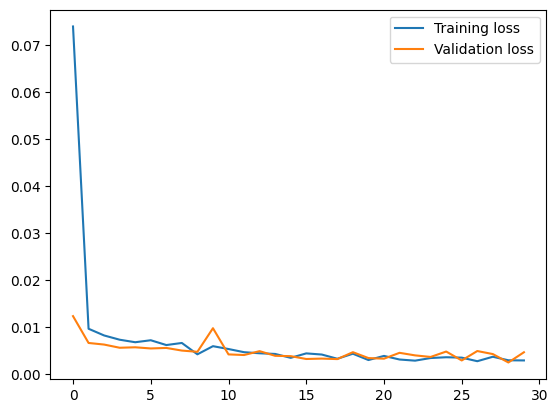

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [17]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)
prediction

5/5 [==============================] - 0s 3ms/step
(140, 1) (140, 1)


array([[1.1238217 ],
       [1.1063336 ],
       [1.0869799 ],
       [1.0256561 ],
       [1.0942388 ],
       [1.1109076 ],
       [1.0511563 ],
       [0.98793226],
       [1.0307436 ],
       [1.0153095 ],
       [0.9526625 ],
       [0.9498925 ],
       [0.9139548 ],
       [0.9340005 ],
       [0.89667743],
       [0.8595217 ],
       [0.8305839 ],
       [0.7721823 ],
       [0.7158704 ],
       [0.67460704],
       [0.7960298 ],
       [0.85746783],
       [0.8418663 ],
       [0.7929877 ],
       [0.84559405],
       [0.87746173],
       [0.98822933],
       [1.0190192 ],
       [1.0254657 ],
       [0.923282  ],
       [0.99784786],
       [0.97784907],
       [0.95350426],
       [0.9611388 ],
       [1.1634892 ],
       [1.1350429 ],
       [1.1360446 ],
       [1.1868925 ],
       [1.1691835 ],
       [1.09217   ],
       [1.0967242 ],
       [1.094234  ],
       [1.0115849 ],
       [0.93184954],
       [0.9236421 ],
       [0.91979605],
       [0.8761312 ],
       [0.921

In [18]:
scaler.mean_[np.newaxis, :]

array([[1.47210774e+02, 1.50496426e+02, 1.43655636e+02, 1.47156436e+02,
        1.32796613e+08]])

In [19]:
# generate array filled with means for prediction
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)
# np.repeat((1, 5), 140, 배열 전체)
mean_values_pred.shape

(140, 5)

In [20]:
# substitute predictions into the first column
mean_values_pred[:, 0] =  np.squeeze(prediction)
mean_values_pred.shape

(140, 5)

In [21]:
# inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:,0]
print(y_pred.shape)

(140,)


In [22]:
# generate array filled with means for testY
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# substitute testY into the first column
mean_values_testY[:, 0] = np.squeeze(testY)

# inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:,0]
print(testY_original.shape)

(140,)


In [23]:
len(test_dates[seq_len:])

140

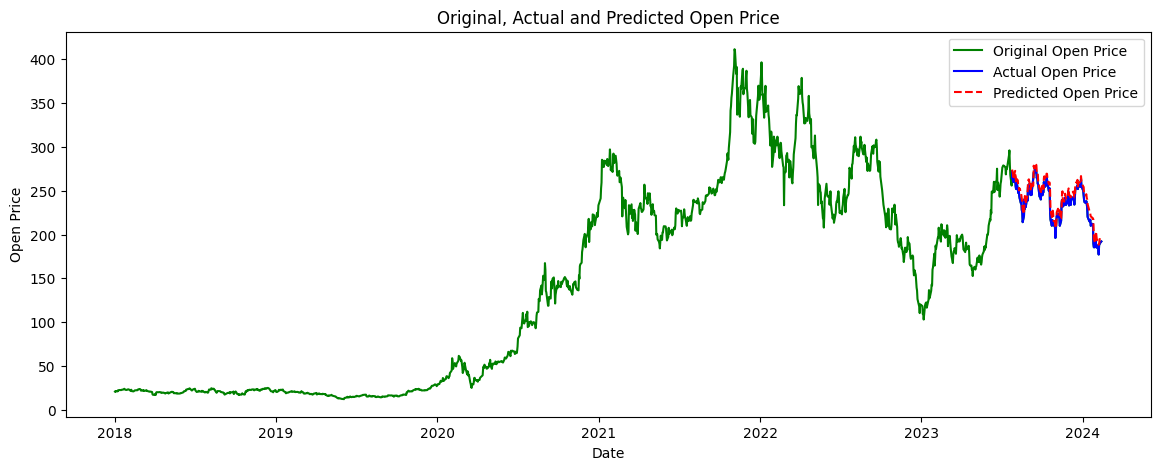

In [24]:
# plotting
plt.figure(figsize=(14, 5))

# plot original 'Open' prices
plt.plot(dates, original_open, color='green', label='Original Open Price')

# plot actual vs predicted
plt.plot(test_dates[seq_len + pred_days - 1:], testY_original, color='blue', label='Actual Open Price')
plt.plot(test_dates[seq_len + pred_days - 1:], y_pred, color='red', linestyle='--', label='Predicted Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Original, Actual and Predicted Open Price')
plt.legend()
plt.show()

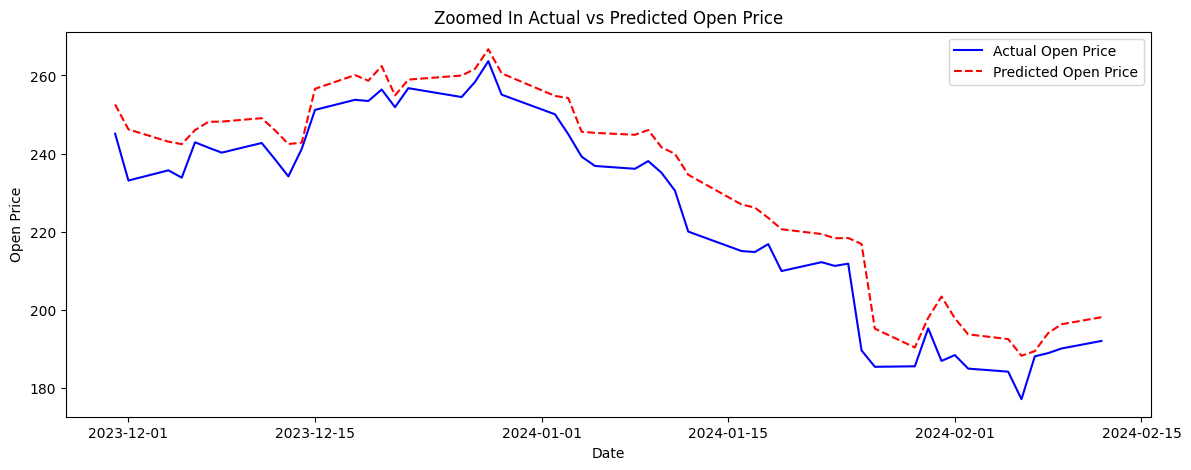

In [25]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start + pred_days - 1:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Open Price')

plt.plot(test_dates[zoom_start + pred_days - 1:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Open Price')

plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Zoomed In Actual vs Predicted Open Price')
plt.legend()
plt.show()